In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from TrackSelectorDNN.models.track_classifier import TrackClassifier
from TrackSelectorDNN.data_manager.dataset_factory import get_dataset
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.stats import binomtest
import numpy as np
from torch.utils.data import DataLoader
import shap
import yaml

Manually look for the best model

In [2]:
'''
run_root = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/"
best_val = float("inf")
best_ckpt_path = None
best_config = None

for trial_name in os.listdir(run_root):
    trial_dir = os.path.join(run_root, trial_name)
    metrics_file = os.path.join(trial_dir, "best_metrics.json")
    ckpt_file = os.path.join(trial_dir, "best_model.pt")

    if os.path.exists(metrics_file):
        with open(metrics_file, "r") as f:
            metrics = json.load(f)
        if metrics["val_loss"] < best_val:
            best_metrics = metrics
            best_val = metrics["val_loss"]
            best_ckpt_path = ckpt_file
            # optionally save config
            config_file = os.path.join(trial_dir, "config.yaml")
            best_config = config_file if os.path.exists(config_file) else None

print("Best checkpoint:", best_ckpt_path)
print("Best val_loss:", best_val)
print("Best config file:", best_config)
'''

'\nrun_root = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/"\nbest_val = float("inf")\nbest_ckpt_path = None\nbest_config = None\n\nfor trial_name in os.listdir(run_root):\n    trial_dir = os.path.join(run_root, trial_name)\n    metrics_file = os.path.join(trial_dir, "best_metrics.json")\n    ckpt_file = os.path.join(trial_dir, "best_model.pt")\n\n    if os.path.exists(metrics_file):\n        with open(metrics_file, "r") as f:\n            metrics = json.load(f)\n        if metrics["val_loss"] < best_val:\n            best_metrics = metrics\n            best_val = metrics["val_loss"]\n            best_ckpt_path = ckpt_file\n            # optionally save config\n            config_file = os.path.join(trial_dir, "config.yaml")\n            best_config = config_file if os.path.exists(config_file) else None\n\nprint("Best checkpoint:", best_ckpt_path)\nprint("Best val_loss:", best_val)\nprint("Best config file:", best_config)\n'

In [3]:
run_root = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/"
results = []

for trial_name in os.listdir(run_root):
    trial_dir = os.path.join(run_root, trial_name)
    metrics_file = os.path.join(trial_dir, "best_metrics.json")
    ckpt_file = os.path.join(trial_dir, "best_model.pt")
    config_file = os.path.join(trial_dir, "config.yaml")

    if os.path.exists(metrics_file):
        with open(metrics_file, "r") as f:
            metrics = json.load(f)

        val_loss = metrics.get("val_loss", None)
        if val_loss is not None:
            results.append({
                "trial": trial_name,
                "val_loss": val_loss,
                "ckpt": ckpt_file,
                "config": config_file if os.path.exists(config_file) else None
            })

# ---- Sort by val_loss ----
results_sorted = sorted(results, key=lambda x: x["val_loss"])

# ---- Take top 5 ----
top10 = results_sorted[:10]

# ---- Print results ----
print("\n=== Top 5 Networks by Lowest val_loss ===")
for i, r in enumerate(top10, 1):
    print(f"\n#{i}")
    print(f"Trial:      {r['trial']}")
    print(f"val_loss:   {r['val_loss']}")
    print(f"Checkpoint: {r['ckpt']}")
    print(f"Config:     {r['config']}")


=== Top 5 Networks by Lowest val_loss ===

#1
Trial:      205c3_00130
val_loss:   0.1945717559340746
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00130/best_model.pt
Config:     /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00130/config.yaml

#2
Trial:      205c3_00132
val_loss:   0.19461190637926565
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00132/best_model.pt
Config:     /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00132/config.yaml

#3
Trial:      205c3_00148
val_loss:   0.1947962403134392
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00148/best_model.pt
Config:     /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00148/config.yaml

#4
Trial:      205c3_00253
val_loss:   0.19490869869549374
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00253/best_model.pt
Config:     /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00253/config.yaml

#5
Trial:      205c3_0

In [4]:
print("\n=== Top 5 Networks by Lowest val_loss ===")
for i, r in enumerate(top10, 1):
    print(f"\n#{i}  Trial: {r['trial']}")
    print(f"val_loss: {r['val_loss']}")
    print(f"Checkpoint: {r['ckpt']}")

    if r["config"] is None:
        print("Config: MISSING")
        continue

    # ---- Load config.yaml ----
    with open(r["config"], "r") as f:
        config = yaml.safe_load(f)

    # ---- Print requested fields ----
    print(
        config.get("lambda_sym", "MISSING"),
        config.get("netA_hidden_dim", "MISSING"),
        config.get("netA_hidden_layers", "MISSING"),
        config.get("latent_dim", "MISSING"),
        config.get("pooling_type", "MISSING"),
        config.get("netB_hidden_dim", "MISSING"),
        config.get("netB_hidden_layers", "MISSING"),
    )


=== Top 5 Networks by Lowest val_loss ===

#1  Trial: 205c3_00130
val_loss: 0.1945717559340746
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00130/best_model.pt
0.008991365157064597 64 3 32 sum 128 3

#2  Trial: 205c3_00132
val_loss: 0.19461190637926565
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00132/best_model.pt
0.05911226532652397 64 3 32 sum 128 2

#3  Trial: 205c3_00148
val_loss: 0.1947962403134392
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00148/best_model.pt
0.00459054353142197 32 2 16 mean 32 3

#4  Trial: 205c3_00253
val_loss: 0.19490869869549374
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00253/best_model.pt
0.0020115041960831925 64 2 16 mean 32 3

#5  Trial: 205c3_00305
val_loss: 0.19493629561341827
Checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00305/best_model.pt
0.0006783166818150203 64 3 16 mean 32 3

#6  Trial: 205c3_00189
val_loss: 0.19518827342752293


In [5]:
PATH = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00253/'
best_config = PATH + 'config.yaml'
best_ckpt_path = PATH + 'best_model.pt'
# Open and load YAML
with open(best_config, "r") as f:
    best_config = yaml.safe_load(f)

Load the validation dataset

In [15]:
#best_config["val_path"] = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/10_tracks_train-val_dataset.pt'

In [6]:
val_ds, collate_fn = get_dataset(best_config, dataset_role="val_path")
train_ds, _= get_dataset(best_config, dataset_role="train_path")
device = "cpu" #"cuda" if torch.cuda.is_available() else
val_loader = DataLoader(val_ds, batch_size=best_config["batch_size"], collate_fn=collate_fn)
train_loader = DataLoader(train_ds, batch_size=best_config["batch_size"], collate_fn=collate_fn)

In [7]:
'''
val_ds.recHitFeatures = torch.cat(
    [val_ds.recHitFeatures,
     torch.zeros(len(val_ds.recHitFeatures), 16, 3)],
    dim=-1
)
'''
train_ds.recHitFeatures.shape, val_ds.recHitFeatures.shape

(torch.Size([146241, 16, 9]), torch.Size([36560, 16, 9]))

build the model

In [8]:
model = TrackClassifier(hit_input_dim = best_config["hit_input_dim"],
                        track_feat_dim = best_config["track_feat_dim"],
                        latent_dim = best_config["latent_dim"],
                        pooling_type = best_config["pooling_type"],
                        # --- NetA parameters ---
                        netA_hidden_dim = best_config["netA_hidden_dim"],
                        netA_hidden_layers = best_config["netA_hidden_layers"],
                        netA_batchnorm = best_config["netA_batchnorm"],
                        netA_activation = best_config["netA_activation"],
                        # --- NetB parameters ---
                        netB_hidden_dim = best_config["netB_hidden_dim"],
                        netB_hidden_layers = best_config["netB_hidden_layers"],
                        netB_batchnorm = best_config["netB_batchnorm"],
                        netB_activation = best_config["netB_activation"]).to(device)


model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
model.eval()

TrackClassifier(
  (pool): MeanPooling()
  (netA): NetA(
    (mlp): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (netB): NetB(
    (mlp): Sequential(
      (0): Linear(in_features=41, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True,

In [9]:
 best_config

{'base_checkpoint_directory': '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs',
 'batch_size': 128,
 'dataset_type': 'production',
 'delta': 0.0,
 'dummy_load_path': None,
 'epochs': 75,
 'hit_input_dim': 9,
 'idxSymRecHitFeatures': [2, 7],
 'idxSymRecoPixelTrackFeatures': [5, 7, 10, 22, 23],
 'lambda_sym': 0.0020115041960831925,
 'latent_dim': 16,
 'lr': 0.0017334529129498309,
 'max_hits': 16,
 'netA_activation': 'relu',
 'netA_batchnorm': True,
 'netA_hidden_dim': 64,
 'netA_hidden_layers': 2,
 'netB_activation': 'relu',
 'netB_batchnorm': True,
 'netB_hidden_dim': 32,
 'netB_hidden_layers': 3,
 'patience': 15,
 'pooling_type': 'mean',
 'test_path': '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_test_dataset.pt',
 'track_feat_dim': 25,
 'train_path': '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train_dataset.pt',
 'val_path': '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_val_dataset.pt',
 'w_fak

In [10]:
def plot_run_losses(run_dir):
    log_file = os.path.join(run_dir, "metrics.csv")  # or whatever CSVLogger writes
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"No metrics.csv found in {run_dir}")

    df = pd.read_csv(log_file)

    # Assumes columns: epoch, train_loss, val_loss
    epochs = df["epoch"]
    train_loss = df["train_loss"]
    val_loss = df["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.show()


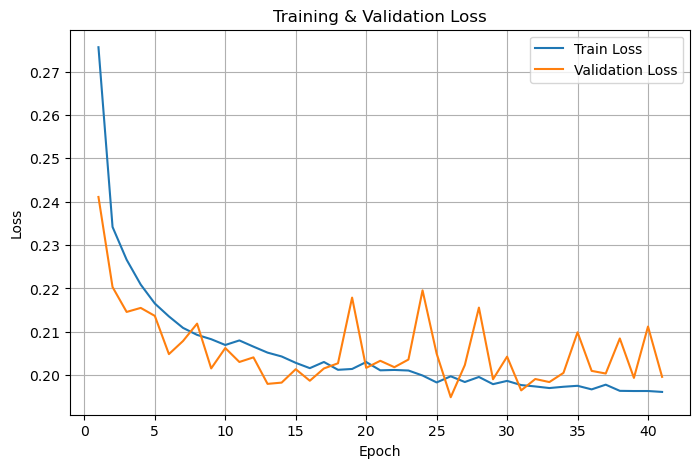

In [11]:
plot_run_losses(PATH)

Rerun inference

In [12]:
def predict(model, data_loader, device):
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            hit_features = batch["hit_features"].to(device)
            track_features = batch["track_features"].to(device)
            mask = batch["mask"].to(device)
           
            preds = torch.sigmoid(model(hit_features, track_features, mask)).cpu().numpy()
            all_preds.append(preds)
    
        all_preds = np.concatenate(all_preds)
    return all_preds 

In [14]:
all_preds = predict(model, val_loader, device)
all_preds_train = predict(model, train_loader, device)

all_isHighPurity = val_ds.isHighPurity.numpy()  
all_labels = val_ds.labels.numpy()  
all_labels_train = train_ds.labels.numpy()  

In [89]:
# ROC curve
fpr_dnn, tpr_dnn, _ = roc_curve(all_labels, all_preds)
fpr_dnn_train, tpr_dnn_train, _ = roc_curve(all_labels_train, all_preds_train)

auc_dnn = auc(fpr_dnn, tpr_dnn)
auc_dnn_train = auc(fpr_dnn_train, tpr_dnn_train)

fpr_hp, tpr_hp, _ = roc_curve(all_labels, all_isHighPurity)
auc_hp = auc(fpr_hp, tpr_hp)

# Accuracy and confusion matrix for DNN
preds_bin = (all_preds > 0.095).astype(int)
acc_dnn = accuracy_score(all_labels, preds_bin)
tn, fp, fn, tp = confusion_matrix(all_labels, preds_bin, normalize='true').ravel()

print(f"✅ DNN Results:")
print(f"  AUC: {auc_dnn:.4f}")
print(f"  Accuracy: {acc_dnn:.4f}")
print(f"  True Positives:  {tp}")
print(f"  False Positives: {fp}")
print(f"  True Negatives:  {tn}")
print(f"  False Negatives: {fn}")

✅ DNN Results:
  AUC: 0.9760
  Accuracy: 0.9306
  True Positives:  0.9856372240791608
  False Positives: 0.33154658678858584
  True Negatives:  0.6684534132114142
  False Negatives: 0.014362775920839262


In [68]:
# Accuracy for legacy classifier
acc_hp = accuracy_score(all_labels, all_isHighPurity)
tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, all_isHighPurity, normalize='true').ravel()

print(f"\n✅ Legacy (isHighPurity) Results:")
print(f"  AUC: {auc_hp:.4f}")
print(f"  Accuracy: {acc_hp:.4f}")
print(f"  True Positives:  {tp_hp}")
print(f"  False Positives: {fp_hp}")
print(f"  True Negatives:  {tn_hp}")
print(f"  False Negatives: {fn_hp}")


✅ Legacy (isHighPurity) Results:
  AUC: 0.6610
  Accuracy: 0.8727
  True Positives:  0.985140814773141
  False Positives: 0.6630931735771717
  True Negatives:  0.3369068264228283
  False Negatives: 0.014859185226859053


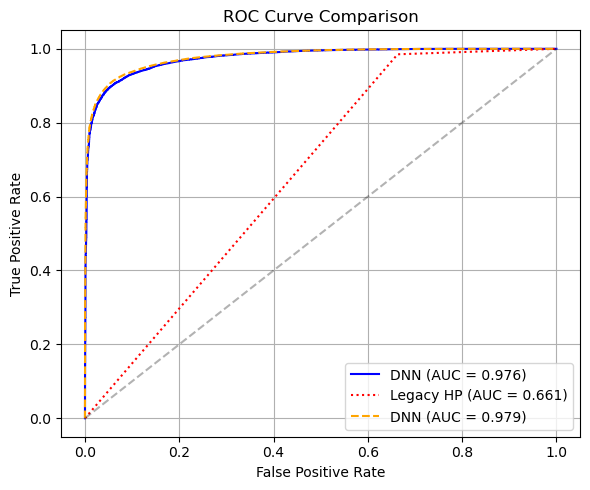

In [91]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_dnn, tpr_dnn, label=f"DNN (AUC = {auc_dnn:.3f})", color='blue')
plt.plot(fpr_hp, tpr_hp, label=f"Legacy HP (AUC = {auc_hp:.3f})", linestyle="dotted", color='red')
plt.plot(fpr_dnn_train, tpr_dnn_train, label=f"DNN (AUC = {auc_dnn_train:.3f})", linestyle="--", color='orange')
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

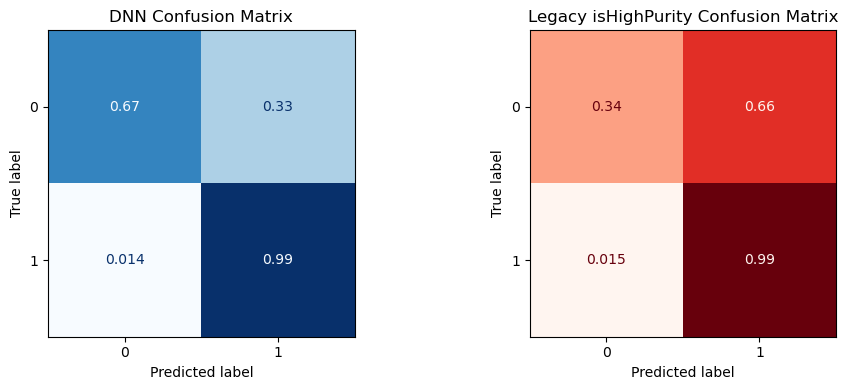

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(confusion_matrix(all_labels, preds_bin, normalize='true')).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("DNN Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(all_labels, all_isHighPurity, normalize='true')).plot(
    ax=axes[1], cmap="Reds", colorbar=False
)
axes[1].set_title("Legacy isHighPurity Confusion Matrix")

for ax in axes:
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

In [51]:
import numpy as np

scores = all_preds.flatten()
labels = all_labels.astype(int)

thresholds = np.linspace(0, 1, 200)

tpr_list = []   # P(pred=1 | true=1)
tnr_list = []   # P(pred=0 | true=0)

for t in thresholds:
    preds_bin = (scores > t).astype(int)

    # mask for classes
    mask0 = (labels == 0)
    mask1 = (labels == 1)

    # TPR
    if mask1.sum() > 0:
        tpr = preds_bin[mask1].mean()
    else:
        tpr = np.nan

    # TNR = P(pred=0 | true=0)
    if mask0.sum() > 0:
        tnr = (1 - preds_bin[mask0]).mean()
    else:
        tnr = np.nan

    tpr_list.append(tpr)
    tnr_list.append(tnr)

tpr_list = np.array(tpr_list)
tnr_list = np.array(tnr_list)

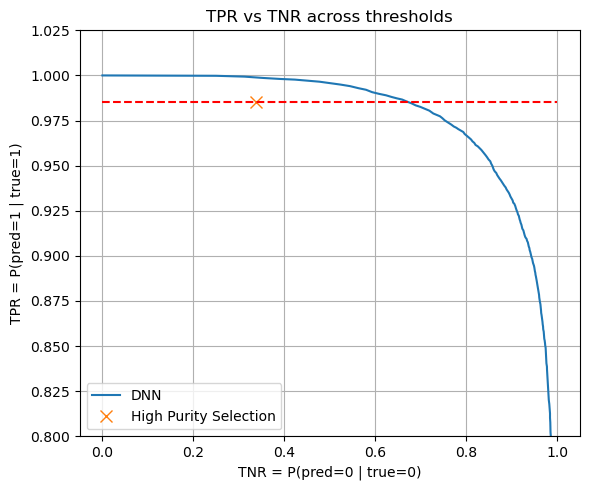

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.plot(tnr_list, tpr_list, '-', label='DNN')
plt.plot(tn_hp, tp_hp, 'x', markersize=8, label='High Purity Selection')
plt.xlabel("TNR = P(pred=0 | true=0)")
plt.ylabel("TPR = P(pred=1 | true=1)")
plt.title("TPR vs TNR across thresholds")
plt.hlines(tp_hp,0,1,'red', 'dashed')
plt.grid(True)
plt.ylim(0.8, 1.025)
plt.tight_layout()
plt.legend(loc='lower left')
plt.show()

In [31]:
# indices where TPR >= required TPR
idx = np.where(tpr_list >= tp_hp)[0]

if len(idx) == 0:
    print("No threshold reaches the required TPR!")
else:
    # choose the *last* threshold that satisfies it (closest above tp_hp)
    best_idx = idx[-1]
    best_threshold = thresholds[best_idx]
    best_tpr = tpr_list[best_idx]
    best_tnr = tnr_list[best_idx]

    print("Threshold:", best_threshold)
    print("TPR:", best_tpr)
    print("TNR:", best_tnr)

Threshold: 0.09547738693467336
TPR: 0.9855710361716914
TNR: 0.6687687214251932


In [32]:
# Load previously exported binning
binning = np.loadtxt("/eos/user/e/ecoradin/sakura/examples/results/binning_fakeVsEta.txt", comments="#")

# Extract only the bin edges for compute_fake_rate
eta_bins = np.unique(np.concatenate([binning[:,0], binning[:,1]]))
eta_centers = 0.5 * (eta_bins[:-1] + eta_bins[1:])
external_fake = binning[:,2]
print("Loaded η bins")

Loaded η bins


In [33]:
def compute_fake_rate(y_true, y_pred_bin, eta, bins, cl=0.683):
    nbins = len(bins) - 1
    fake_rate = np.full(nbins, np.nan)
    fake_err_low = np.full(nbins, np.nan)
    fake_err_up  = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (eta >= bins[i]) & (eta < bins[i+1])
        if sel.sum() == 0:
            continue

        predicted_real = (y_pred_bin[sel] == 1)
        #print(predicted_real.shape, predicted_real.sum(), y_true[sel].sum())
        total = predicted_real.sum()
        if total == 0:
            continue

        fake = ((y_true[sel] == 0) & predicted_real).sum()

        # central value
        p = fake / total
        fake_rate[i] = p

        # binomial confidence interval
        result = binomtest(fake, total)
        ci = result.proportion_ci(confidence_level=cl)

        fake_err_low[i] = p - ci.low
        fake_err_up[i]  = ci.high - p
    
    return fake_rate, fake_err_low, fake_err_up

def compute_efficiency(y_true, y_pred_bin, eta, bins, cl=0.683):
    nbins = len(bins) - 1
    eff = np.full(nbins, np.nan)
    eff_err_low = np.full(nbins, np.nan)
    eff_err_up  = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (eta >= bins[i]) & (eta < bins[i+1])

        true_sel = sel & (y_true == 1)
        total = true_sel.sum()
        if total == 0:
            continue

        passed = (y_pred_bin[true_sel] == 1).sum()

        # central value
        p = passed / total
        eff[i] = p

        # binomial confidence interval
        result = binomtest(passed, total)
        ci = result.proportion_ci(confidence_level=cl)

        eff_err_low[i] = p - ci.low
        eff_err_up[i]  = ci.high - p

    return eff, eff_err_low, eff_err_up

# --- Recover raw η ---
eta_idx = val_ds.recoPixelTrackBranches.index("hltPixelTrack_eta")

eta_norm = val_ds.recoPixelTrackFeatures[:, eta_idx].numpy()
eta_mean = val_ds.recoPixelTrack_mean[0, eta_idx].numpy()
eta_std  = val_ds.recoPixelTrack_std[0, eta_idx].numpy()

eta_vals = eta_norm * eta_std + eta_mean   # <-- raw η

# --- Threshold predictions ---
preds_bin = (all_preds > 0.095).astype(int)
labels = all_labels.astype(int)
hp = all_isHighPurity.astype(int)

# --- Binomial CI fake rates ---
print('---- DNN ') 
fake_rate_dnn, fake_low_dnn, fake_up_dnn = compute_fake_rate(labels, preds_bin, eta_vals, eta_bins)
print('---- HP ')
fake_rate_hp,  fake_low_hp,  fake_up_hp  = compute_fake_rate(labels, hp,       eta_vals, eta_bins)
print('---- Worst ')
fake_rate_worst,  fake_low_worst,  fake_up_worst  = compute_fake_rate(labels, np.ones_like(labels),       eta_vals, eta_bins)

# --- Binomial CI efficiency ---
eff_dnn, eff_low_dnn, eff_up_dnn = compute_efficiency(labels, preds_bin, eta_vals, eta_bins)
eff_hp,  eff_low_hp,  eff_up_hp  = compute_efficiency(labels, hp,       eta_vals, eta_bins)


---- DNN 
---- HP 
---- Worst 


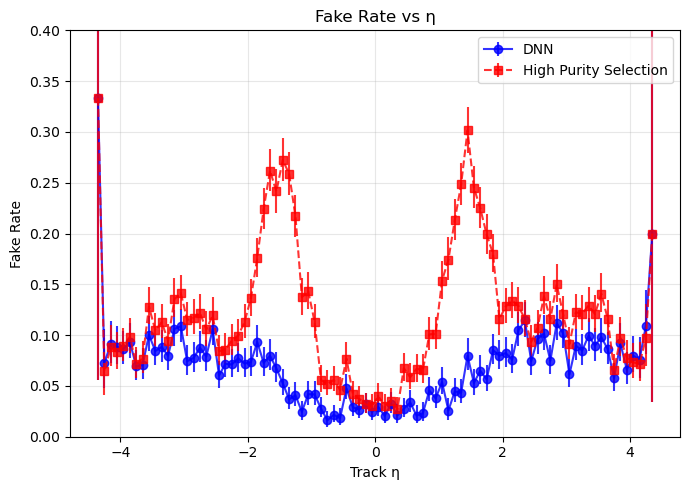

In [72]:
# --- Plot Fake Rate ---
plt.figure(figsize=(7,5))
plt.errorbar(
    eta_centers, fake_rate_dnn,
    yerr=[fake_low_dnn, fake_up_dnn],
    fmt='o-', label='DNN', alpha=0.8, color='blue',
)

plt.errorbar(
    eta_centers, fake_rate_hp,
    yerr=[fake_low_hp, fake_up_hp],
    fmt='s--', label='High Purity Selection', alpha=0.8, color = 'red'
)
#plt.errorbar(
#    eta_centers, fake_rate_worst,
#    yerr=[fake_low_worst, fake_up_worst],
#    fmt='s--', label='Worst classifier', alpha=0.8
#)
#plt.plot(eta_centers, external_fake)
plt.xlabel('Track η')
plt.ylabel('Fake Rate')
plt.title('Fake Rate vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0,0.4)
plt.tight_layout()
plt.show()

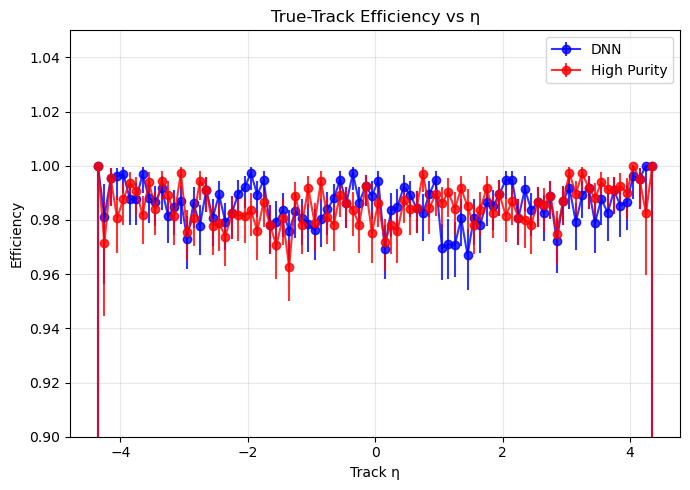

In [76]:
# --- Plot Efficiency ---
plt.figure(figsize=(7,5))
plt.errorbar(
    eta_centers, eff_dnn,
    yerr=[eff_low_dnn, eff_up_dnn],
    fmt='o-', label='DNN', color='blue', alpha=0.8
)

plt.errorbar(
    eta_centers, eff_hp,
    yerr=[eff_low_hp, eff_up_hp],
    fmt='o-', label='High Purity', color='red', alpha=0.8
)
plt.xlabel('Track η')
plt.ylabel('Efficiency')
plt.title('True-Track Efficiency vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0.90, 1.05)
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, hp).ravel()
tpr_hp = tp_hp / (tp_hp + fn_hp)

print("Legacy TPR:", tpr_hp)
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
idx = np.argmin(np.abs(tpr - tpr_hp))

best_threshold = thresholds[idx]
tpr_dnn_at_best = tpr[idx]
fpr_dnn_at_best = fpr[idx]

print("Best DNN threshold:", best_threshold)
print("DNN TPR at matched point:", tpr_dnn_at_best)
print("DNN FPR at matched point:", fpr_dnn_at_best)

Legacy TPR: 0.985140814773141
Best DNN threshold: 0.09821232
DNN TPR at matched point: 0.985140814773141
DNN FPR at matched point: 0.3242944978716696


In [122]:
ratio = np.array(eff_dnn)/np.array(eff_hp)
np.nanmin(ratio), np.nanmax(ratio)

(np.float64(0.9805194805194805), np.float64(1.017857142857143))